In [8]:
using Pkg; Pkg.activate("."); 
using MUST
using PyPlot
using DelimitedFiles
using Glob
using Interpolations
using Statistics
using LaTeXStrings

MUST.@import_dispatch "../../../dispatch2_clean/dispatch2" 
MUST.@import_dispatch "../../../dispatch2_clean/dispatch2" EOS 
MUST.@get_help visual

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/visualize/Project.toml`


In [9]:
function read_patch_diags(path)
    diag_files = glob("debug_info*", MUST.@in_dispatch(path))
    r = []
    for f in diag_files
        data = readdlm(f, header=true)
        d = Dict(data[2][i]=>data[1][:,i] for i in eachindex(data[2]))
        append!(r, [d])
    end

    r
end;

In [10]:
uniqueind(x) = unique(i -> x[i], eachindex(x))

function interpolate_patch(patch)
    d = Dict()
    paras = [p for p in keys(patch) if !(p=="time")]

    for p in paras
        t = uniqueind(patch["time"])
        d[p] = LinearInterpolation(patch["time"][t], patch[p][t])
    end

    d
end;

In [11]:
function average_over_time(patches; tbins=100)
    time_min = maximum( [minimum(p["time"]) for p in patches] )
    time_max = minimum( [maximum(p["time"]) for p in patches] )
    time = range(time_min, time_max; length=tbins)

    paras = [p for p in keys(patches[1]) if !(p=="time")]

    result      = Dict(p=>similar(time) for p in keys(patches[1]))
    patches_int = interpolate_patch.(patches)

    m = zeros(length(patches))
    for i in eachindex(time)
        for j in eachindex(paras)
            m .= 0.0
            for k in eachindex(patches)
                m[k] = patches_int[k][paras[j]](time[i])
            end
            result[paras[j]][i] = mean(m)
        end
    end

    result["time"] = time
    result
end;

In [12]:
patch_data_sq = read_patch_diags("data/solar_model_sqg_stag");
patch_data_st = read_patch_diags("data/solar_model_sqg_stag_src");

In [13]:
av_sq = average_over_time(patch_data_sq, tbins=120);
av_st = average_over_time(patch_data_st, tbins=120);

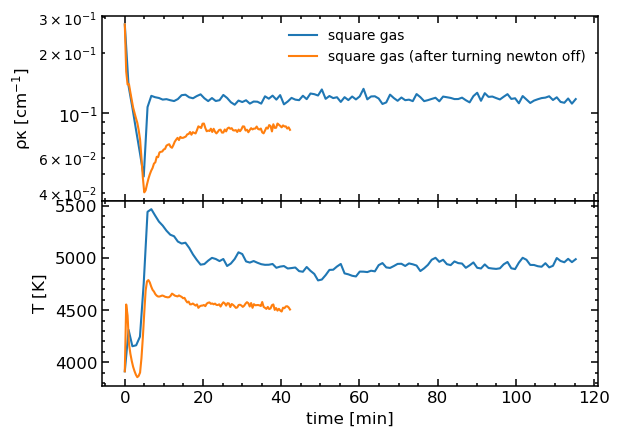

In [14]:
f,ax = plt.subplots(2,1, sharex=true)
basic_plot!.(ax)
plt.subplots_adjust(hspace=0)

ax[1].plot(av_sq["time"], av_sq["rk1"], label="square gas")
ax[1].plot(av_st["time"], av_st["rk1"], label="square gas (after turning newton off)");
ax[1].legend(framealpha=0)
ax[1].set_yscale("log")
ax[1].set_ylabel(L"\rm \rho \kappa \ [cm^{-1}]", fontsize="large")

ax[2].plot(av_sq["time"], av_sq["T"], label="square gas")
ax[2].plot(av_st["time"], av_st["T"], label="square gas (low T)")
ax[2].set_ylabel(L"\rm T \ [K]", fontsize="large")
ax[2].set_xlabel("time [min]", fontsize="large");
